In [1]:
library(tidyverse)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.1     ✔ dplyr   0.7.4
✔ tidyr   0.7.2     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



#  Full GENESIS dataset

In 10 separate simulations, we simulated subnetworks of 20 causal genes, and 50% of their SNPs were assigned as causal. Then, we tried to recover them, and measured some quality measures.

In [2]:
bm <- read_tsv("roc.tsv")
params <- gsub("L", "", bm$selection) %>% strsplit("-E", fixed = T)
params <- do.call(rbind, params)
bm <- mutate(bm, lambda = factor(params[,1], 
                                 levels = c('1e-1.0','1e-0.5','1e0.0','1e0.5','1e1.0','1e1.5',
                                             '1e2.0','1e2.5','1e3.0','1e3.5','1e4.0')), 
                 eta = factor(params[,2], 
                              levels = unique(sort(params[,2]))),
                 LD = ifelse(LD, "With LD", "Without LD"),
                 net = factor(toupper(net), levels = c("GS", "GM", "GI", "GI2")))

Parsed with column specification:
cols(
  .default = col_double(),
  model = col_character(),
  test = col_character(),
  statistic = col_character(),
  selection = col_character(),
  id = col_integer(),
  net = col_character(),
  LD = col_logical(),
  realSnps = col_integer(),
  realGenes = col_integer(),
  detectedSnps = col_integer(),
  detectedGenes = col_integer(),
  detectedPGenes = col_integer()
)
See spec(...) for full column specifications.


We first did a benchmark on simulations on the full GENESIS dataset. We focused on values of etas between 1 and 1000, and lambdas between ~0.3 and 10,000, which proved to be the sweet spot for good parameters in previous simulations

## Precision-recall

Although simulations were performed for h<sup>2</sup> of 0.25 and 1, we will only display results for h<sup>2</sup> = 1. For h<sup>2</sup> = 0.25 the signal is dimmer and every metric is worse, but the patterns are similar. We also tried including LD information in the edges using a sigmoid function, but the results barely changed.

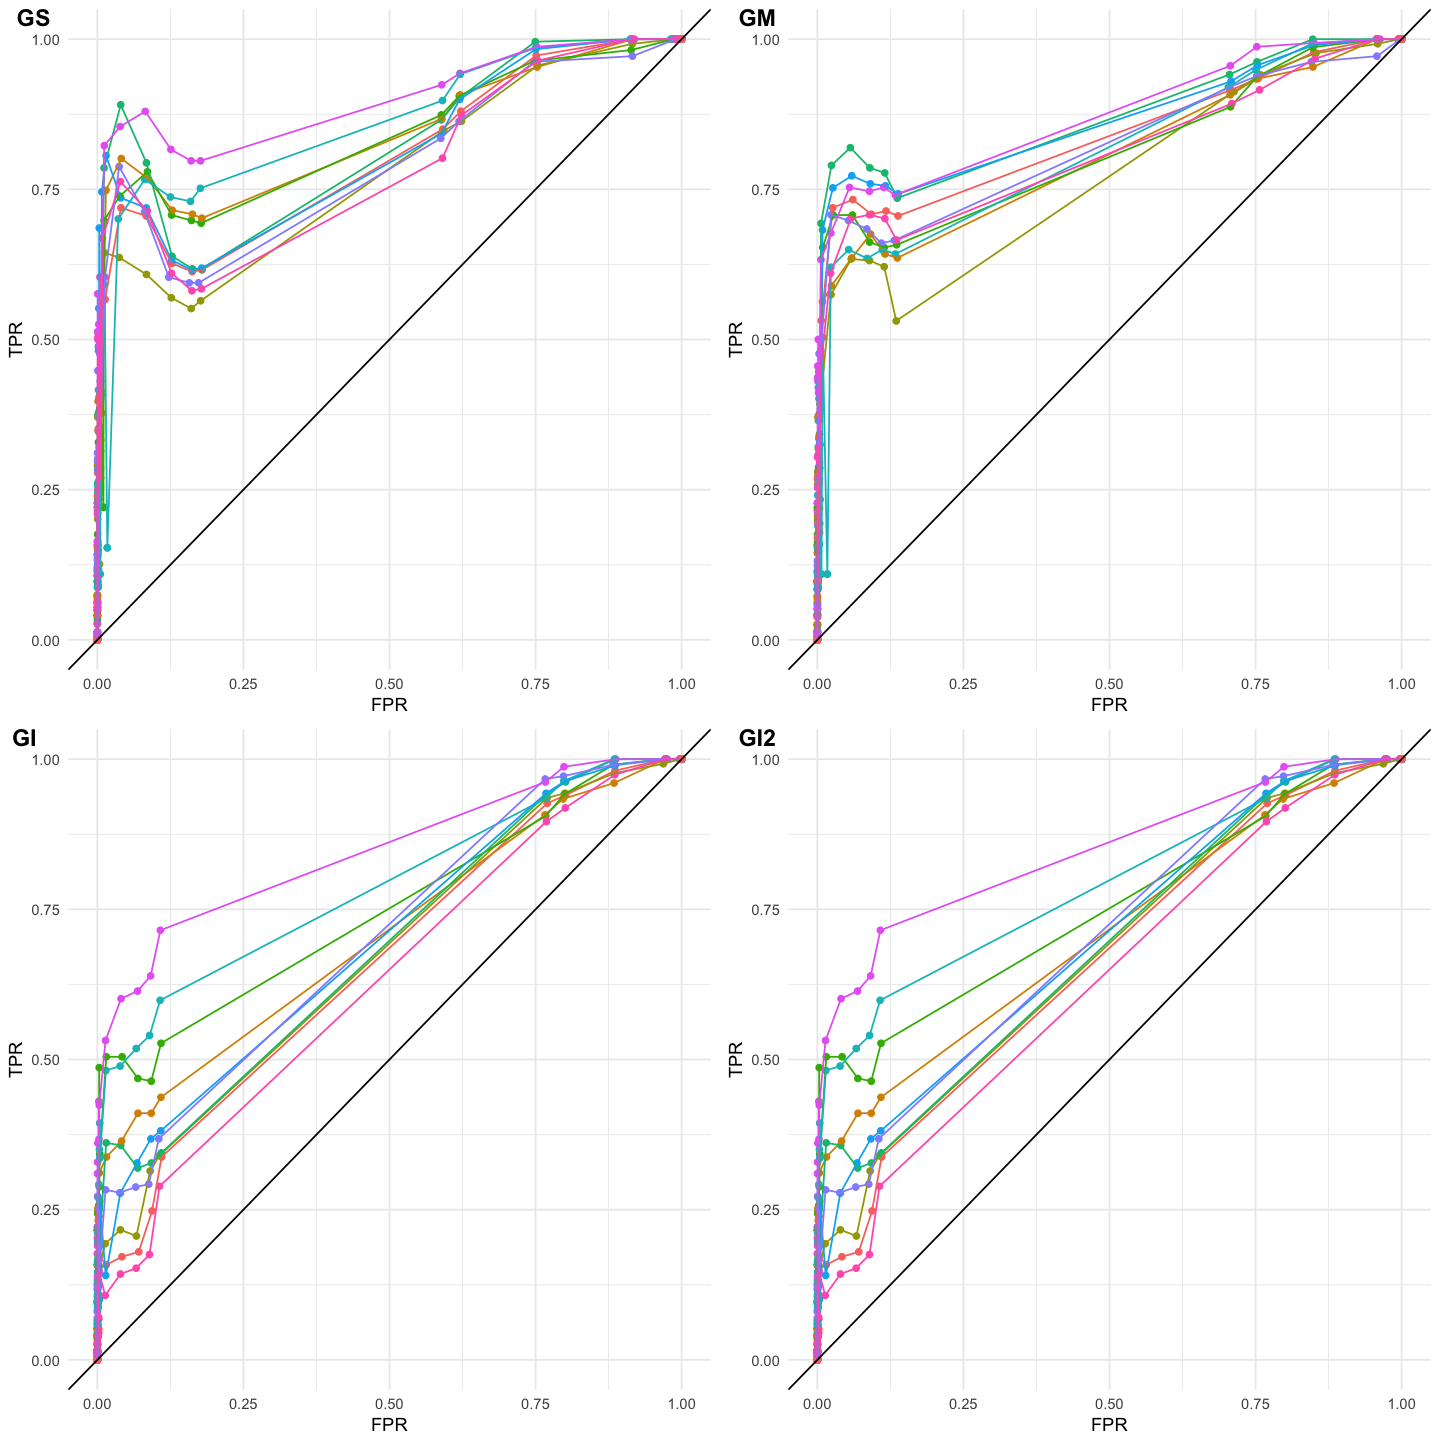

In [3]:
options(repr.plot.width=12, repr.plot.height=12)
plt <- lapply(c("GS","GM","GI","GI"), function(n) {
    filter(bm, net == n & LD == "Without LD" & h2 == 1) %>%
    ggplot(aes(x = 1 - Specificity, y = Sensitivity, color = as.character(id))) +
        geom_point() +
        geom_line() +
        geom_abline(slope = 1, intercept = 0) +
        theme_minimal() +
        labs(x = "FPR", y = "TPR") +
        theme(legend.position = "none") +
        scale_fill_gradient(limits=c(0,1), low = "#edf8b1", high = "#e6550d")
})


plot_grid(plt[[1]], plt[[2]], plt[[3]], plt[[4]],
          nrow = 2, ncol = 2, labels = c("GS", "GM", "GI", "GI2"))

$TPR=\frac {TP} {TP + FN}$

$FPR=\frac {FP} {FP + TN}$.

Interestingly, GS and GM show a best AUC than GI and GI2. That might be due to the fact that the solution is easily findable under GS and GM assumptions, while GI introduces more noise than signal in the network. It seems that there is a range of hyperparameters for which we barely get (proportionally) almost any false positive, while getting 60-80% of the causal SNPs.

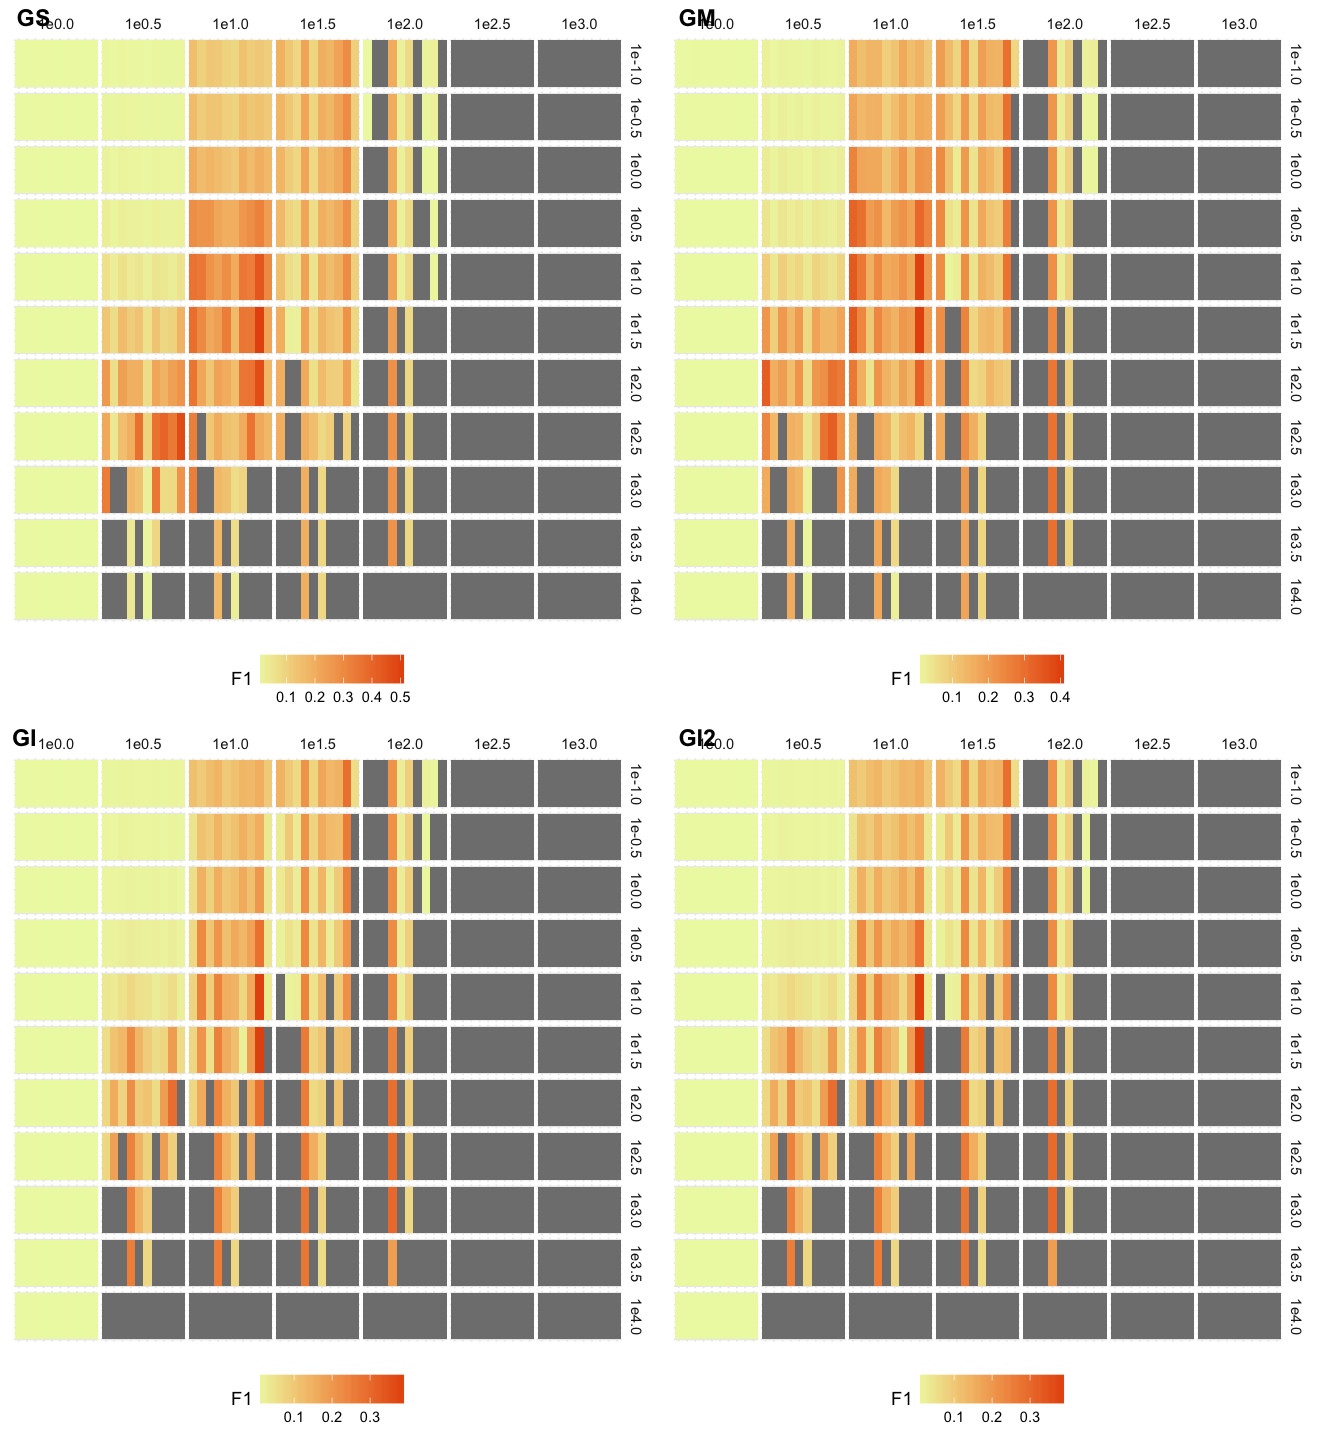

In [4]:
options(repr.plot.width=11, repr.plot.height=12)
plt <- lapply(c("GS","GM","GI","GI"), function(n) {
    filter(bm, net == n & LD == "Without LD" & h2 == 1) %>%
    ggplot(aes(x = as.character(id), y = 1, fill = F1)) +
        geom_tile() +
        facet_grid(lambda ~ eta) +
        theme_minimal() +
        theme(legend.position="bottom",
              axis.title.x=element_blank(), axis.title.y=element_blank(),
              axis.text.x=element_blank(), axis.text.y=element_blank(),
              axis.ticks.x=element_blank(), axis.ticks.y=element_blank(),
              panel.spacing = unit(0.1, "lines")) +
        scale_fill_gradient(low = "#edf8b1", high = "#e6550d")
})


plot_grid(plt[[1]], plt[[2]], plt[[3]], plt[[4]],
          nrow = 2, ncol = 2, labels = c("GS", "GM", "GI", "GI2"))

$Precision=\frac {TP} {TP + FP}$

$Recall = TPR =\frac {TP} {TP + FN}$

$F1 = 2 \times \frac {precision \times recall} {precision + recall}$

Alternatively, we can look at the F1 score to check the balance between precision and recall. Precision might be more informative than FPR, as a small fraction of the SNPs relative to all of the SNPs can still be a huge chunk of the SNPs.

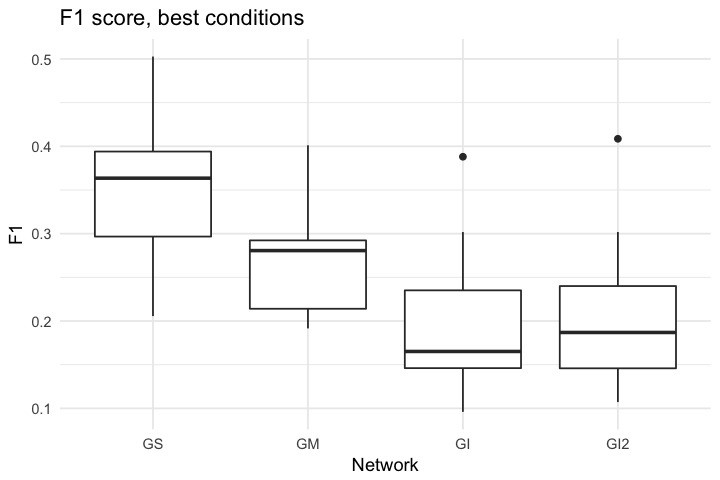

In [5]:
options(repr.plot.width=6, repr.plot.height=4)
bm %>%
    filter(h2 == 1 & LD == "Without LD") %>%
    group_by(LD, net, id) %>%
    summarize(F1 = F1[which.max(F1)]) %>%
    ggplot(aes(x = net, y = F1)) +
        geom_boxplot() +
        theme_minimal() +
        labs(title = "F1 score, best conditions", x = "Network")

Under this view, we are not doing that well, and the more prior knowledge we add, the worse the solution is.

## Ratio detected to causal SNPs

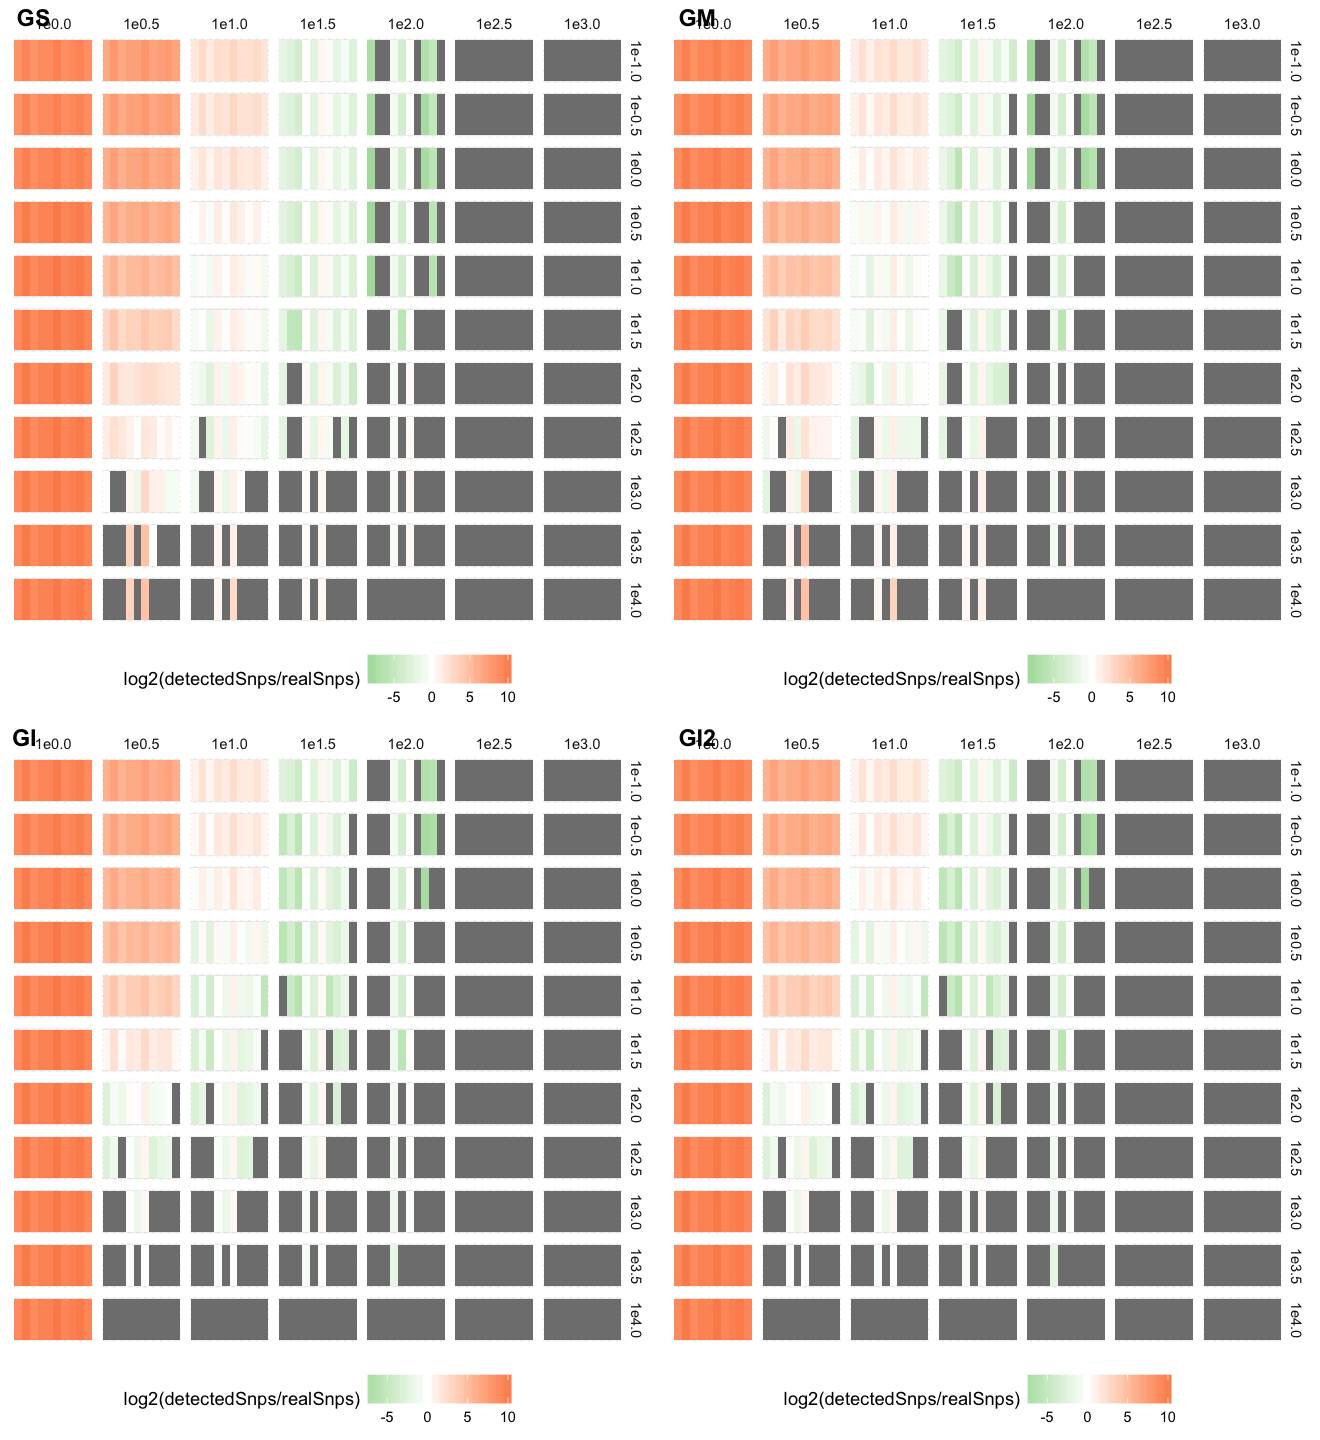

In [6]:
options(repr.plot.width=11, repr.plot.height=12)
plt <- lapply(c("GS","GM","GI","GI"), function(n) {
    filter(bm, net == n & LD == "Without LD" & h2 == 1) %>%
    ggplot(aes(x = as.character(id), y = 1, fill = log2(detectedSnps/realSnps)) ) +
        geom_tile() +
        facet_grid(lambda ~ eta) +
        theme_minimal() +
        theme(legend.position="bottom",
              axis.title.x=element_blank(), axis.title.y=element_blank(),
              axis.text.x=element_blank(), axis.text.y=element_blank(),
              axis.ticks.x=element_blank(), axis.ticks.y=element_blank()) +
        scale_fill_gradient2(low = "#99d594", high = "#fc8d59", mid = "white")
})

plot_grid(plt[[1]], plt[[2]], plt[[3]], plt[[4]],
          nrow = 2, ncol = 2, labels = c("GS", "GM", "GI", "GI2"))

## Elapsed time

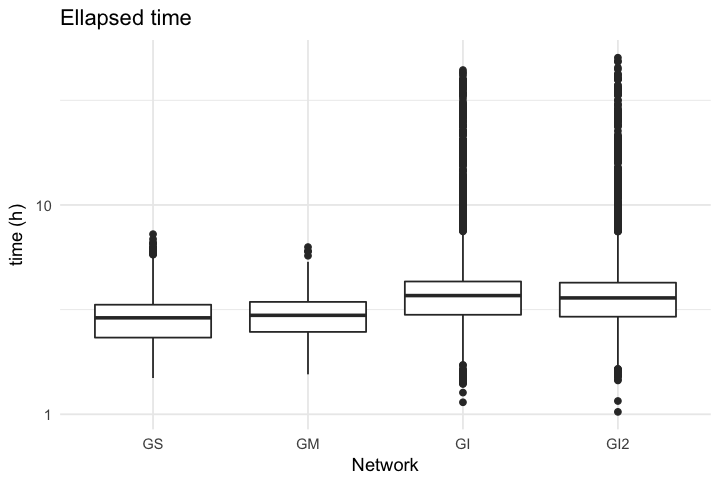

In [7]:
options(repr.plot.width=6, repr.plot.height=4)
ggplot(bm, aes(x = net, y = time)) +
    geom_boxplot() +
    scale_y_log10() +
    theme_minimal() +
    labs(title = "Ellapsed time", x = "Network", y = 'time (h)')

# LD-pruned GENESIS

We wondered if the relative failure of SConES could be due to the peculiarities of GENESIS dataset. This includes a very high density on genes deemed as interesting which, in turn, means that the LD distribution will be higher than in a normal GWAS dataset. This could be the reason for the low utility of GI: first, associated SNPs are tightly connected to other SNPs in high LD; second, adding an interactor is heavily penalized if if it not strongly associated to the phenotype.

We performed an LD prune on GENESIS: any pair of SNPs that was in LD > 0.8 was simplified to a single SNP. We did this in the hope of converting GENESIS into a more conventional dataset.

In [8]:
bm <- read_tsv("roc_pruned.tsv")
params <- gsub("L", "", bm$selection) %>% strsplit("-E", fixed = T) %>% do.call(rbind, .)
bm <- mutate(bm, lambda = factor(params[,1], 
                                 levels = unique(sort(params[,2]))), 
                 eta = factor(params[,2], 
                              levels = unique(sort(params[,2]))),
                 LD = ifelse(LD, "With LD", "Without LD"),
                 net = factor(toupper(net), levels = c("GS", "GM", "GI", "GI2")))

Parsed with column specification:
cols(
  .default = col_double(),
  model = col_character(),
  test = col_character(),
  statistic = col_character(),
  selection = col_character(),
  id = col_integer(),
  net = col_character(),
  LD = col_logical(),
  realSnps = col_integer(),
  realGenes = col_integer(),
  detectedSnps = col_integer(),
  detectedGenes = col_integer(),
  detectedPGenes = col_integer()
)
See spec(...) for full column specifications.


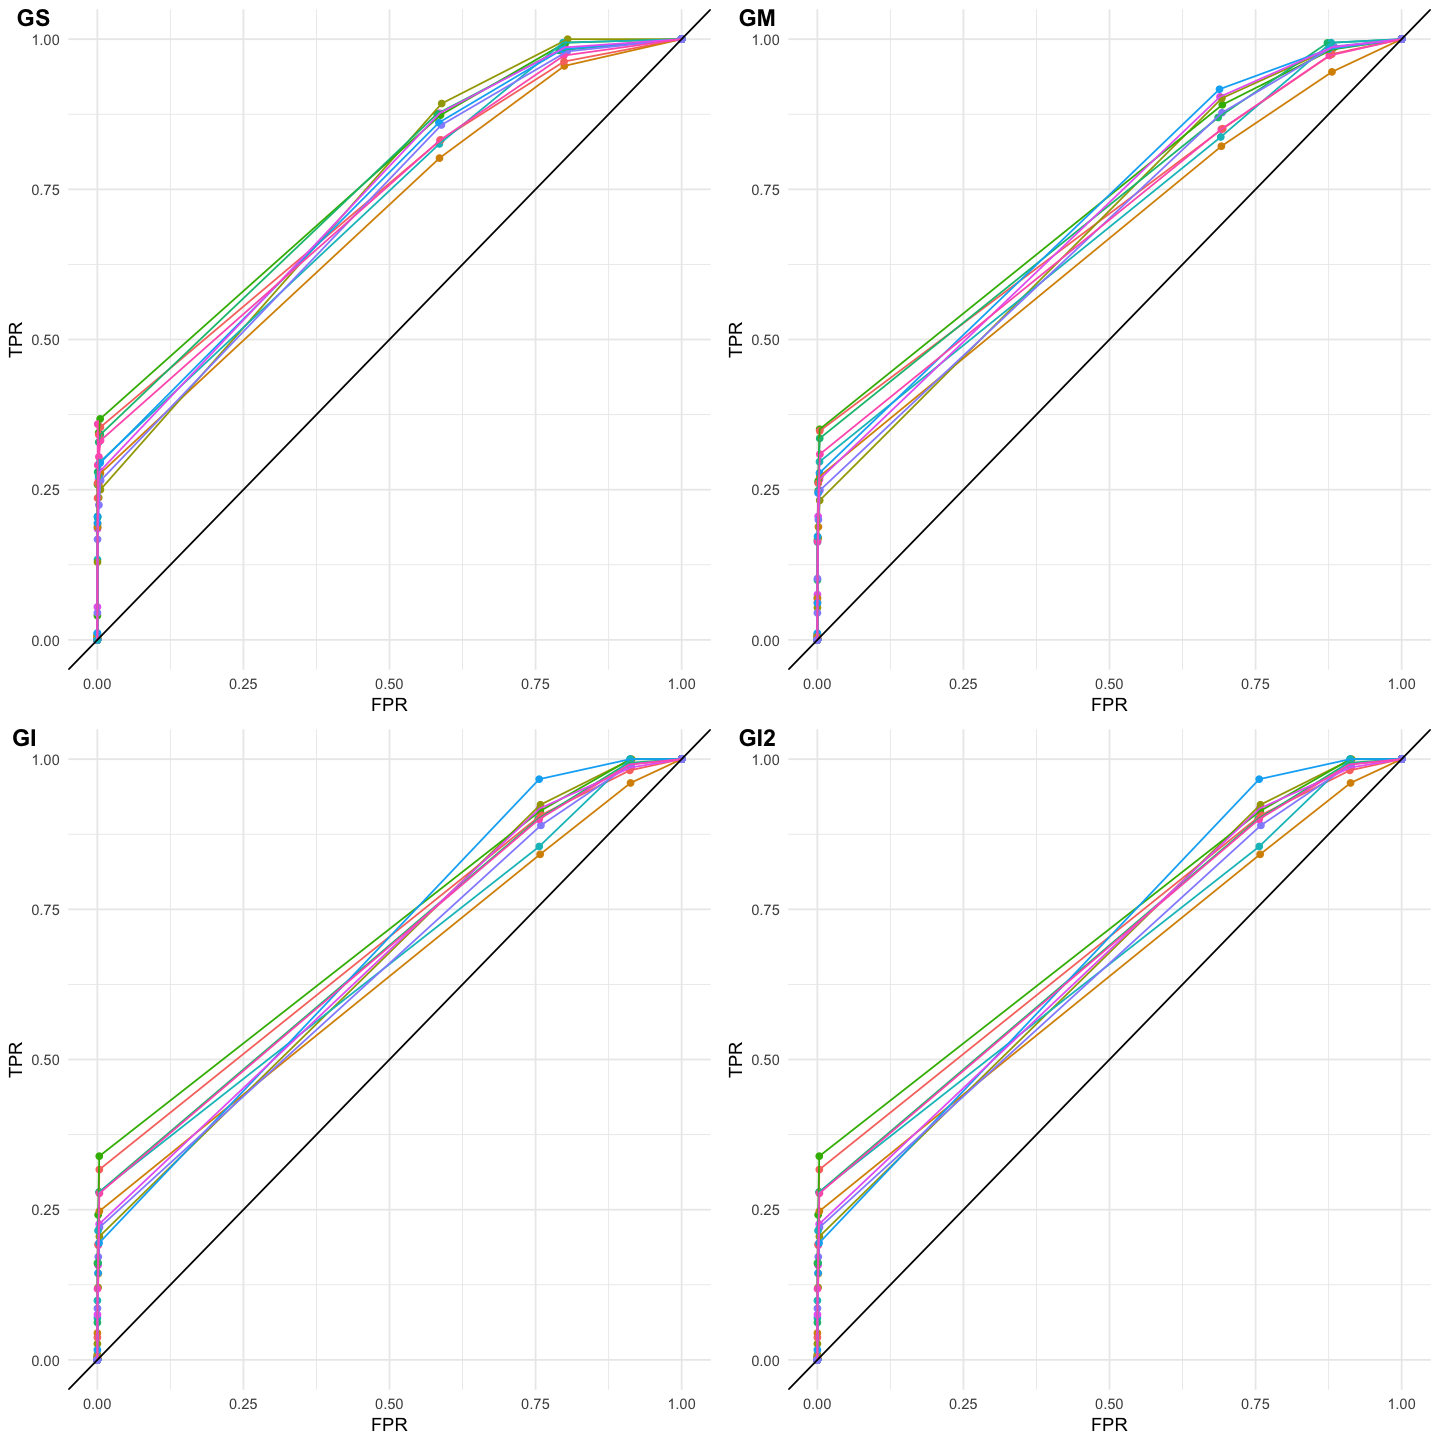

In [9]:
options(repr.plot.width=12, repr.plot.height=12)
plt <- lapply(c("GS","GM","GI","GI"), function(n) {
    filter(bm, net == n & LD == "Without LD" & h2 == 1) %>%
    ggplot(aes(x = 1 - Specificity, y = Sensitivity, color = as.character(id))) +
        geom_point() +
        geom_line() +
        geom_abline(slope = 1, intercept = 0) +
        theme_minimal() +
        labs(x = "FPR", y = "TPR") +
        theme(legend.position = "none") +
        scale_fill_gradient(limits=c(0,1), low = "#edf8b1", high = "#e6550d")
})


plot_grid(plt[[1]], plt[[2]], plt[[3]], plt[[4]],
          nrow = 2, ncol = 2, labels = c("GS", "GM", "GI", "GI2"))

The AUC is worse than in the full dataset.

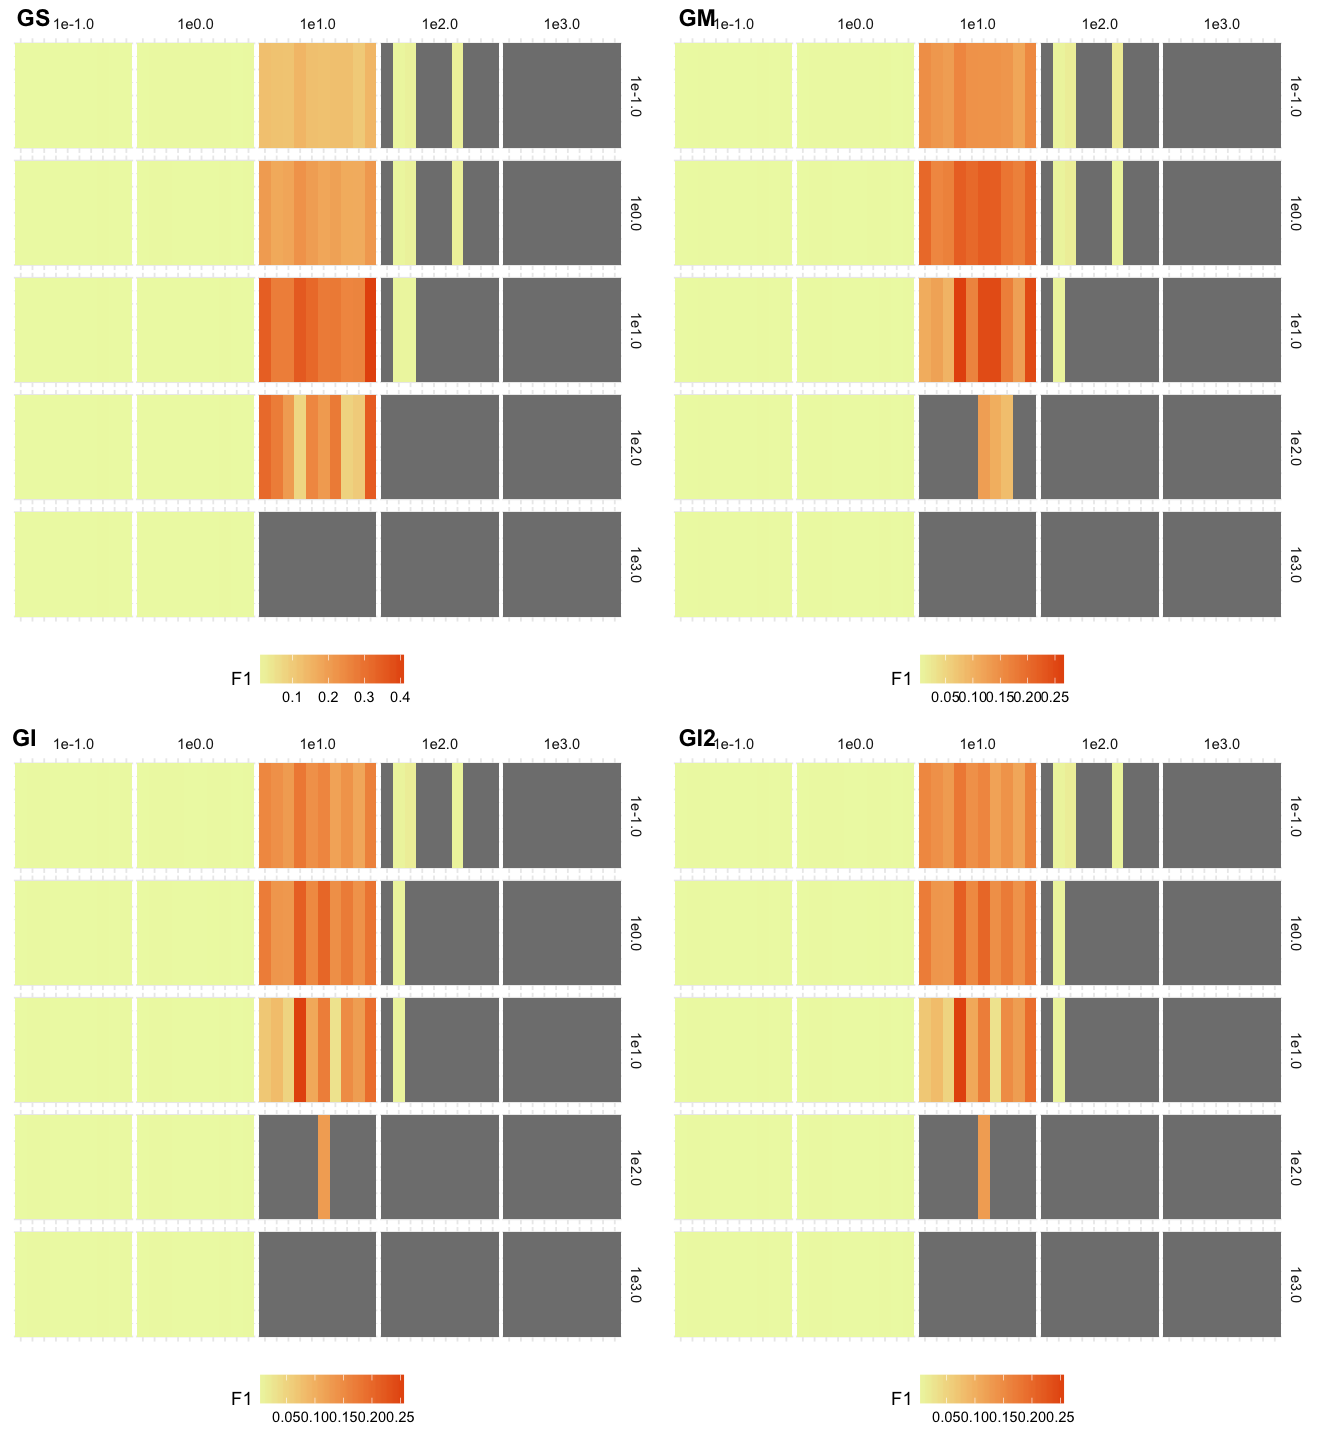

In [10]:
options(repr.plot.width=11, repr.plot.height=12)
plt <- lapply(c("GS","GM","GI","GI"), function(n) {
    filter(bm, net == n & LD == "Without LD" & h2 == 1) %>%
    ggplot(aes(x = as.character(id), y = 1, fill = F1)) +
        geom_tile() +
        facet_grid(lambda ~ eta) +
        theme_minimal() +
        theme(legend.position="bottom",
              axis.title.x=element_blank(), axis.title.y=element_blank(),
              axis.text.x=element_blank(), axis.text.y=element_blank(),
              axis.ticks.x=element_blank(), axis.ticks.y=element_blank(),
              panel.spacing = unit(0.1, "lines")) +
        scale_fill_gradient(low = "#edf8b1", high = "#e6550d")
})


plot_grid(plt[[1]], plt[[2]], plt[[3]], plt[[4]],
          nrow = 2, ncol = 2, labels = c("GS", "GM", "GI", "GI2"))

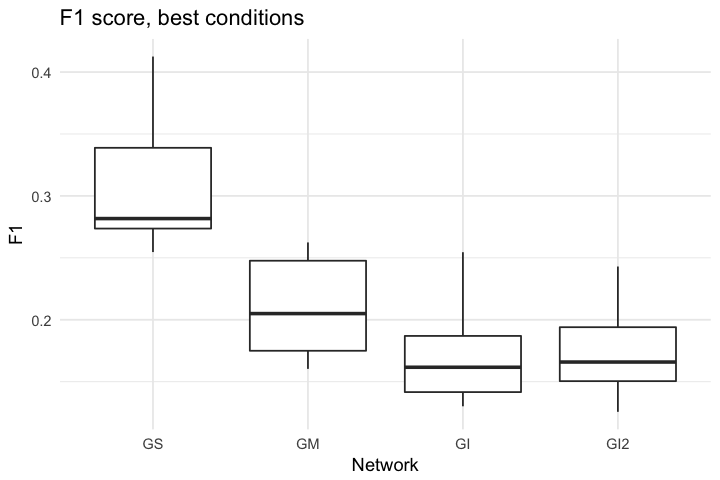

In [11]:
options(repr.plot.width=6, repr.plot.height=4)
bm %>%
    filter(h2 == 1 & LD == "Without LD") %>%
    group_by(LD, net, id) %>%
    summarize(F1 = F1[which.max(F1)]) %>%
    ggplot(aes(x = net, y = F1)) +
        geom_boxplot() +
        theme_minimal() +
        labs(title = "F1 score, best conditions", x = "Network")

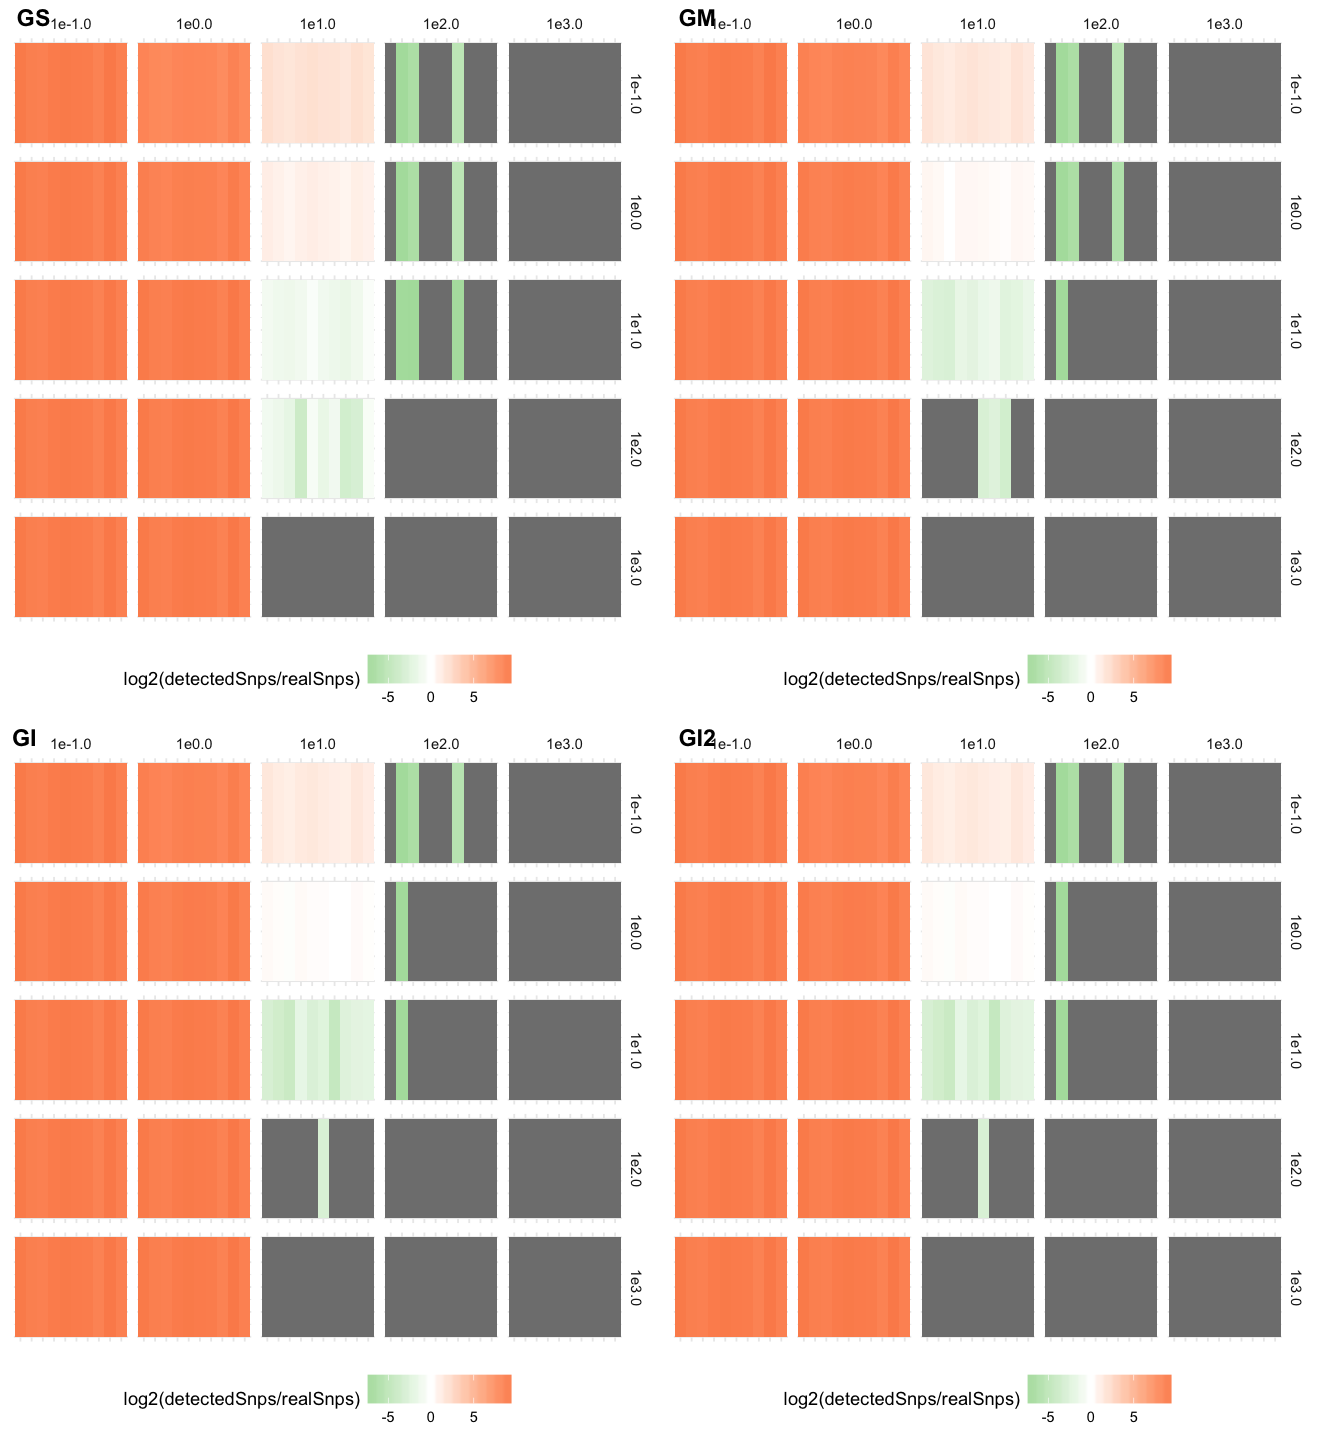

In [12]:
options(repr.plot.width=11, repr.plot.height=12)
plt <- lapply(c("GS","GM","GI","GI"), function(n) {
    filter(bm, net == n  & LD == "Without LD" & h2 == 1) %>%
    ggplot(aes(x = as.character(id), y = 1, fill = log2(detectedSnps/realSnps)) ) +
        geom_tile() +
        facet_grid(lambda ~ eta) +
        theme_minimal() +
        theme(legend.position="bottom",
              axis.title.x=element_blank(), axis.title.y=element_blank(),
              axis.text.x=element_blank(), axis.text.y=element_blank(),
              axis.ticks.x=element_blank(), axis.ticks.y=element_blank()) +
        scale_fill_gradient2(low = "#99d594", high = "#fc8d59", mid = "white")
})

plot_grid(plt[[1]], plt[[2]], plt[[3]], plt[[4]],
          nrow = 2, ncol = 2, labels = c("GS", "GM", "GI", "GI2"))